In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import chi2
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde

from empiricaldist import Pmf
from empiricaldist import Cdf

from fractions import Fraction
from matplotlib import pyplot as plt
from scipy.stats import binom
from scipy.interpolate import interp1d

In [3]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

In [4]:
def make_joint(s1, s2):
    """Compute the outer product of two Series.

    First Series goes across the columns;
    second goes down the rows.

    s1: Series
    s2: Series

    return: DataFrame
    """
    X, Y = np.meshgrid(s1, s2)
    return pd.DataFrame(X*Y, columns=s1.index, index=s2.index)

In [5]:
def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [6]:
def plot_contour(joint, **options):
    """Plot a joint distribution.

    joint: DataFrame representing a joint PMF
    """
    low = joint.to_numpy().min()
    high = joint.to_numpy().max()
    levels = np.linspace(low, high, 6)
    levels = levels[1:]

    underride(options, levels=levels, linewidths=1)
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name,
             ylabel=joint.index.name)
    return cs

In [7]:
def normalize(joint):
    """Normalize a joint distribution.

    joint: DataFrame
    """
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

In [8]:
def marginal(joint, axis):
    """Compute a marginal distribution.

    axis=0 returns the marginal distribution of the first variable
    axis=1 returns the marginal distribution of the second variable

    joint: DataFrame representing a joint distribution
    axis: int axis to sum along

    returns: Pmf
    """
    return Pmf(joint.sum(axis=axis))

In [9]:
def kde_from_sample(sample, qs, **options):
    """Make a kernel density estimate from a sample

    sample: sequence of values
    qs: quantities where we should evaluate the KDE

    returns: normalized Pmf
    """
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs, **options)
    pmf.normalize()
    return pmf

In [10]:
def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

In [11]:
def set_pyplot_params():
    # plt.rcParams['figure.dpi'] = 300
    plt.rcParams['axes.prop_cycle'] = color_cycle
    plt.rcParams['lines.linewidth'] = 3

## Improving Reading Ability

We'll use data from a [Ph.D. dissertation in educational psychology](https://docs.lib.purdue.edu/dissertations/AAI8807671/) written in 1987, which was used as an example in a [statistics textbook](https://books.google.com/books/about/Introduction_to_the_practice_of_statisti.html?id=pGBNhajABlUC) from 1989 and published on [DASL](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html), a web page that collects data stories.  

Here's the description from DASL:

> An educator conducted an experiment to test whether new directed reading activities in the classroom will help elementary school pupils improve some aspects of their reading ability. She arranged for a third grade class of 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the 8 weeks, all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

The [dataset is available here](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html).

In [12]:
#download('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv')

In [13]:
df = pd.read_csv('drp_scores.csv', skiprows=21, delimiter='\t')
df.head(3)

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58


In [14]:
df.shape

(44, 2)

In [15]:
df.groupby('Treatment').size()

Treatment
Control    23
Treated    21
dtype: int64

In [16]:
df.groupby('Treatment').min(), df.groupby('Treatment').max()

(           Response
 Treatment          
 Control          10
 Treated          24,
            Response
 Treatment          
 Control          85
 Treated          71)

In [17]:
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']

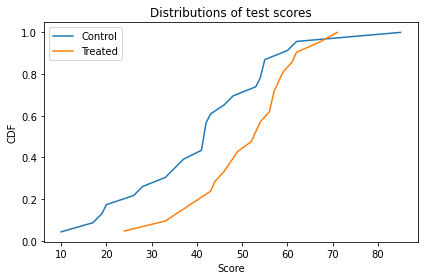

In [18]:
for name, response in responses.items():
    cdf = Cdf.from_seq(response)
    cdf.plot(label=name)
    
decorate(xlabel='Score', 
         ylabel='CDF',
         title='Distributions of test scores')

There is overlap between the distributions, but it looks like the scores are higher in the treated group. The distribution of scores is not exactly normal for either group, but it is close enough that the normal model is a reasonable choice.

So I’ll assume that in the entire population of students (not just the ones in the experiment), the distribution of scores is well modeled by a normal distribution with unknown mean and standard deviation. I’ll use `mu` and `sigma` to denote these unknown parameters, and we’ll do a Bayesian update to estimate what they are.

## Prior

* Assume that in the entire population of students (not just the ones in the experiment), the distribution of scores is well modeled by a normal distribution with unknown mean (`mu`) and standard deviation (`sigma`).

* Assume that the prior distributions for `mu` and `sigma` are uniform. 

In [19]:
qs = np.linspace(20, 80, num=101)
prior_mu = make_uniform(qs, name='mean')
prior_mu.head()

,probs
mean,
20.0,0.009901
20.6,0.009901
21.2,0.009901


In [20]:
qs = np.linspace(5, 30, num=101)
prior_sigma = make_uniform(qs, name='std')
prior_sigma.head()

,probs
std,
5.00,0.009901
5.25,0.009901
5.50,0.009901


In [21]:
prior = make_joint(prior_mu, prior_sigma)

## Likelihood

In [22]:
data = responses['Control']
data.shape

(23,)

In [23]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
mu_mesh.shape

(101, 101, 23)

In [24]:
densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(101, 101, 23)

In [25]:
likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)

In [26]:
def update_norm(prior, data):
    """Update the prior based on data."""
    mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    
    densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)
    
    posterior = prior * likelihood
    normalize(posterior)

    return posterior

In [27]:
data = responses['Control']
posterior_control = update_norm(prior, data)

In [28]:
data = responses['Treated']
posterior_treated = update_norm(prior, data)

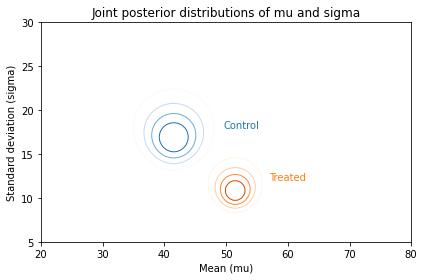

In [29]:
plot_contour(posterior_control, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean (mu)', 
         ylabel='Standard deviation (sigma)',
         title='Joint posterior distributions of mu and sigma')

## Posterior Marginal Distributions

In [30]:
pmf_mean_control = marginal(posterior_control, 0)
pmf_mean_treated = marginal(posterior_treated, 0)

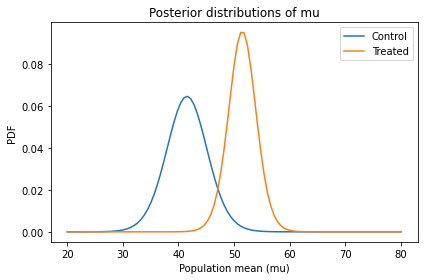

In [31]:
pmf_mean_control.plot(label='Control')
pmf_mean_treated.plot(label='Treated')

decorate(xlabel='Population mean (mu)', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

In [32]:
Pmf.prob_gt(pmf_mean_treated, pmf_mean_control)

0.9804790251873259

There is a 98% chance that the mean in the treated group is higher.

In [129]:
pmf_std_control = marginal(posterior_control, 1)
pmf_std_treated = marginal(posterior_treated, 1)

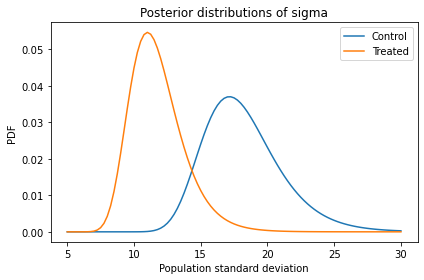

In [130]:
pmf_std_control.plot(label='Control')
pmf_std_treated.plot(label='Treated')

decorate(xlabel='Population standard deviation', 
         ylabel='PDF', 
         title='Posterior distributions of sigma')

In [131]:
Pmf.prob_gt(pmf_std_control, pmf_std_treated)

0.9685103375300469

## Distribution of Differences

In [33]:
pmf_diff = Pmf.sub_dist(pmf_mean_treated, pmf_mean_control)

In [34]:
len(pmf_mean_treated), len(pmf_mean_control), len(pmf_diff)

(101, 101, 879)

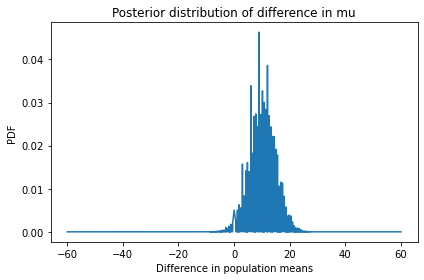

In [35]:
pmf_diff.plot()

decorate(xlabel='Difference in population means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

In [36]:
cdf_diff = pmf_diff.make_cdf()

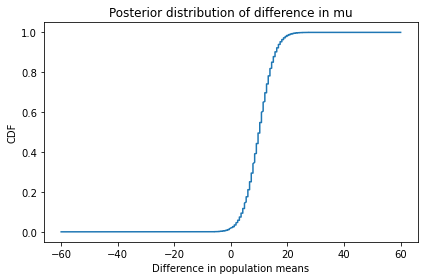

In [37]:
cdf_diff.plot()

decorate(xlabel='Difference in population means', 
         ylabel='CDF', 
         title='Posterior distribution of difference in mu')

In [38]:
def kde_from_pmf(pmf, n=101):
    """Make a kernel density estimate for a PMF."""
    kde = gaussian_kde(pmf.qs, weights=pmf.ps)
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [39]:
kde_diff = kde_from_pmf(pmf_diff)

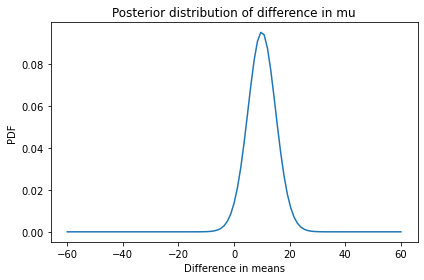

In [40]:
kde_diff.plot()

decorate(xlabel='Difference in means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

In [41]:
pmf_diff.mean()

9.954413088940848

In [42]:
pmf_diff.credible_interval(0.9)

array([ 2.4, 17.4])

Based on this interval, we are pretty sure the treatment improves test scores by 2 to 17 points.

In [132]:
pmf_diff2 = Pmf.sub_dist(pmf_std_control, pmf_std_treated)

In [133]:
pmf_diff2.mean()

6.41717132817218

In [134]:
pmf_diff2.credible_interval(0.9)

array([ 1. , 12.5])

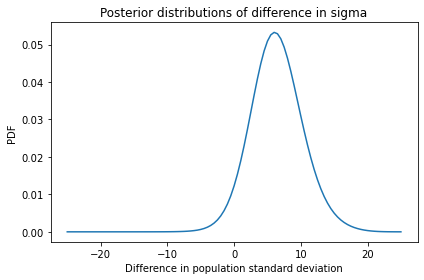

In [135]:
kde_from_pmf(pmf_diff2).plot()

decorate(xlabel='Difference in population standard deviation', 
         ylabel='PDF', 
         title='Posterior distributions of difference in sigma')

Based on this interval, we are pretty sure the treatment improves test scores by 2 to 17 points.

## Using Summary Statistics

In this example the dataset is not very big, so it doesn’t take too long to compute the probability of every score under every hypothesis. But the result is a 3-D array; for larger datasets, it might be too big to compute practically.

Also, with larger datasets the likelihoods get very small, sometimes so small that we can’t compute them with floating-point arithmetic. That’s because we are computing the probability of a particular dataset; the number of possible datasets is astronomically big, so the probability of any of them is very small.

An alternative is to compute a summary of the dataset and compute the likelihood of the summary. For example, if we compute the mean and standard deviation of the data, we can compute the likelihood of those summary statistics under each hypothesis.

Suppose we know that the actual mean of the population, $\mu$,  is 42 and the actual standard deviation, $\sigma$, is 17.

In [43]:
mu = 42
sigma = 17

Suppose we draw a sample from this distribution with sample size `n=20`, and compute the mean of the sample, which we call `m`, and the standard deviation of the sample, which we call `s`.

In [44]:
n = 20
m = 41
s = 18


* Given $\mu$ and $\sigma$, the distribution of `m` is normal with parameters $\mu$ and $\sigma/\sqrt{n}$;

* The distribution of $s$ is more complicated, but if we compute the transform $t = n s^2 / \sigma^2$, the distribution of $t$ is chi-squared with parameter $n-1$; and

* According to [Basu's theorem](https://en.wikipedia.org/wiki/Basu%27s_theorem), `m` and `s` are independent.

In [45]:
dist_m = norm(mu, sigma / np.sqrt(n))

In [46]:
like1 = dist_m.pdf(m)
like1

0.10137915138497372

In [47]:
t = n * s**2 / sigma**2
t

22.422145328719722

In [48]:
dist_s = chi2(n-1)

In [49]:
like2 = dist_s.pdf(t)
like2

0.04736427909437004

In [50]:
like = like1 * like2
like

0.004801750420548287

## Update with Summary Statistics

In [51]:
summary = {}

for name, response in responses.items():
    summary[name] = len(response), response.mean(), response.std()
    
summary

{'Control': (23, 41.52173913043478, 17.148733229699484),
 'Treated': (21, 51.476190476190474, 11.00735684721381)}

In [52]:
n, m, s = summary['Control']

In [81]:
prior.head()

mean,20.0,20.6,21.2,21.8,22.4,23.0,23.6,24.2,24.8,25.4,...,74.6,75.2,75.8,76.4,77.0,77.6,78.2,78.8,79.4,80.0
std,,,,,,,,,,,,,,,,,,,,,
5.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.25,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.50,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.75,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
6.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098


In [54]:
mus, sigmas = np.meshgrid(prior.columns, prior.index)
mus.shape

(101, 101)

In [55]:
like1 = norm(mus, sigmas/np.sqrt(n)).pdf(m)
like1.shape

(101, 101)

In [56]:
ts = n * s**2 / sigmas**2
like2 = chi2(n-1).pdf(ts)
like2.shape

(101, 101)

In [57]:
posterior_control2 = prior * like1 * like2
normalize(posterior_control2)

0.00030965351017402847

In [58]:
def update_norm_summary(prior, data):
    """Update a normal distribution using summary statistics."""
    n, m, s = data
    mu_mesh, sigma_mesh = np.meshgrid(prior.columns, prior.index)
    
    like1 = norm(mu_mesh, sigma_mesh/np.sqrt(n)).pdf(m)
    like2 = chi2(n-1).pdf(n * s**2 / sigma_mesh**2)
    
    posterior = prior * like1 * like2
    normalize(posterior)
    
    return posterior

In [59]:
data = summary['Treated']
posterior_treated2 = update_norm_summary(prior, data)

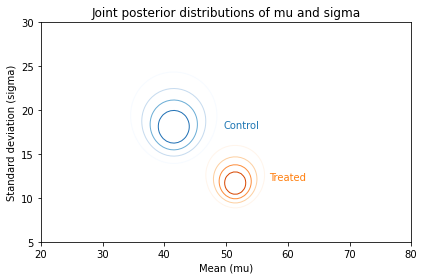

In [60]:
plot_contour(posterior_control2, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated2, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean (mu)', 
         ylabel='Standard deviation (sigma)',
         title='Joint posterior distributions of mu and sigma')

## Comparing Marginals

In [61]:
pmf_mean_control2 = marginal(posterior_control2, 0)
pmf_mean_treated2 = marginal(posterior_treated2, 0)

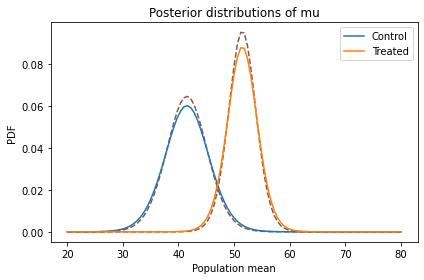

In [62]:
pmf_mean_control.plot(color='C5', linestyle='dashed')
pmf_mean_control2.plot(label='Control')
pmf_mean_treated.plot(color='C5', linestyle='dashed')
pmf_mean_treated2.plot(label='Treated')

decorate(xlabel='Population mean', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

The posterior distributions based on summary statistics are similar to the posteriors we computed using the entire dataset, but in both cases they are shorter and a little wider.

That’s because the update with summary statistics is based on the implicit assumption that the distribution of the data is normal. But it’s not; as a result, when we replace the dataset with the summary statistics, we lose some information about the true distribution of the data. With less information, we are less certain about the parameters.

## Proof By Simulation
The update with summary statistics is based on theoretical distributions, and it seems to work, but I think it is useful to test theories like this, for a few reasons:

* It confirms that our understanding of the theory is correct,

* It confirms that the conditions where we apply the theory are conditions where the theory holds,

* It confirms that the implementation details are correct. For many distributions, there is more than one way to specify the parameters. If you use the wrong specification, this kind of testing will help you catch the error.

In this section I’ll use simulations to show that the distribution of the sample mean and standard deviation is as I claimed. But if you want to take my word for it, you can skip this section and the next.

In [63]:
mu = 42
sigma = 17

In [64]:
dist = norm(mu, sigma)

In [65]:
n = 20
samples = dist.rvs((1000, n))
samples.shape

(1000, 20)

In [66]:
sample_means = samples.mean(axis=1)
sample_means.shape

(1000,)

In [67]:
def pmf_from_dist(dist, low, high):
    """Make a discrete approximation of a continuous distribution.
    
    dist: SciPy dist object
    low: low end of range
    high: high end of range
    
    returns: normalized Pmf
    """
    qs = np.linspace(low, high, 101)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [68]:
low = dist_m.mean() - dist_m.std() * 3
high = dist_m.mean() + dist_m.std() * 3

pmf_m = pmf_from_dist(dist_m, low, high)

In [69]:
qs = pmf_m.qs
pmf_sample_means = kde_from_sample(sample_means, qs)

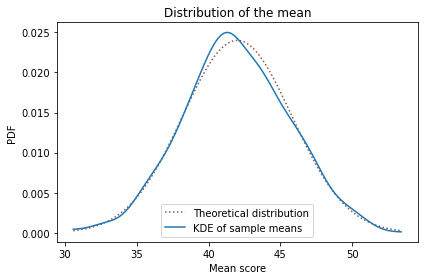

In [70]:
pmf_m.plot(label='Theoretical distribution',
           style=':', color='C5')
pmf_sample_means.plot(label='KDE of sample means')

decorate(xlabel='Mean score',
         ylabel='PDF',
         title='Distribution of the mean')

In [71]:
sample_stds = samples.std(axis=1)
sample_stds.shape

(1000,)

In [72]:
transformed = n * sample_stds**2 / sigma**2

In [73]:
dist_s = chi2(n-1)

In [74]:
low = 0
high = dist_s.mean() + dist_s.std() * 4

pmf_s = pmf_from_dist(dist_s, low, high)

In [75]:
qs = pmf_s.qs
pmf_sample_stds = kde_from_sample(transformed, qs)

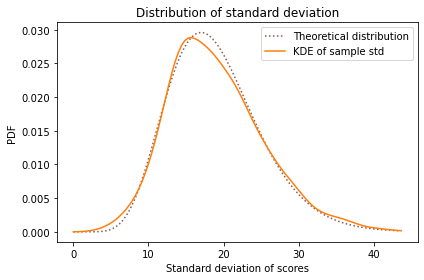

In [76]:
pmf_s.plot(label='Theoretical distribution',
           style=':', color='C5')
pmf_sample_stds.plot(label='KDE of sample std',
                     color='C1')

decorate(xlabel='Standard deviation of scores',
         ylabel='PDF',
         title='Distribution of standard deviation')

In [77]:
corr = np.corrcoef(sample_means, sample_stds)
print(corr)

[[ 1.         -0.02104852]
 [-0.02104852  1.        ]]


In [78]:
corr[0][1]

-0.021048518349882316

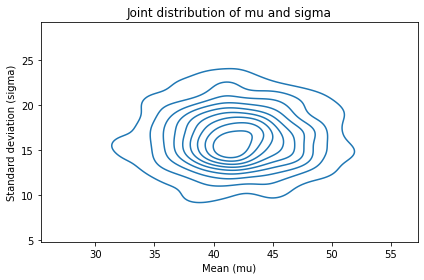

In [79]:
sns.kdeplot(x=sample_means, y=sample_stds)

decorate(xlabel='Mean (mu)',
         ylabel='Standard deviation (sigma)',
         title='Joint distribution of mu and sigma')